<a href="https://colab.research.google.com/github/barbaroja2000/multi_armed_bandits/blob/main/Multi_Armed_Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Armed Bandits

Single Product per arm example.

In [2]:
#@title  Initialization with business metrics for each product
product_ids = [923410,648951,962013,658394,687694,971880,909192,783379,986841,611613]
business_objectives = [2,10,4,3,1,3,1,5,10,7]

# Define 10 distinct colors
colors = [
    (255, 0, 0),   # Red
    (0, 255, 0),   # Green
    (0, 0, 255),   # Blue
    (255, 255, 0), # Yellow
    (0, 255, 255), # Cyan
    (255, 0, 255), # Magenta
    (128, 128, 0), # Olive
    (0, 128, 128), # Teal
    (128, 0, 128), # Purple
    (255, 165, 0)  # Orange
]

In [6]:
from PIL import Image
from PIL import Image, ImageDraw, ImageFont

def generate_colored_images(colors, image_size=(100, 100)):
    """Generate a list of images each of a specified color."""
    images = []
    for color in colors:
        img = Image.new('RGB', image_size, color=color)
        images.append(img)
    return images

def concatenate_images_horizontally(product_ids, business_objectives):
    # Assuming each image is 100x100 pixels
    total_width = 100 * len(product_ids)
    max_height = 100

    new_img = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for image_id, business_objective in zip(product_ids, business_objectives):
        img = Image.open(f'product_{image_id}.png')
        draw = ImageDraw.Draw(img)

        # Using a simple font. For a custom font, you can use ImageFont.truetype("path_to_font.ttf", size)
        font = ImageFont.load_default()

        # Drawing product ID and business objective on the top-left corner
        draw.text((5, 5), f"ID: {image_id}", font=font, fill="white")
        draw.text((5, 15), f"Obj: {business_objective}", font=font, fill="white")

        new_img.paste(img, (x_offset, 0))
        x_offset += img.width

    return new_img

In [7]:
# Generate product thumbnails
product_thumbnails = generate_colored_images(colors)

# Save each thumbnail with filenames based on image_ids
for product_id, img in zip(product_ids, product_thumbnails):
    path = f"product_{product_id}.png"
    img.save(path)

In [8]:
# Concatenate and display the images
concatenated_image = concatenate_images_horizontally(product_ids, business_objectives)

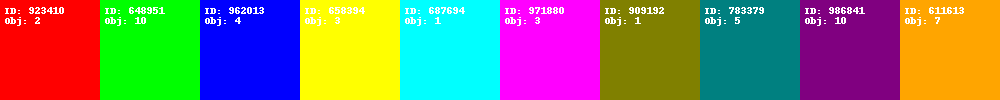

In [9]:
#@title Product Thumbnails and Business Objectives
display(concatenated_image)

In [10]:
import random
from typing import List
import math

# Base Bandit class
class BaseBandit:
    def __init__(self, product_ids: List[str], business_metrics: List[int]):
        assert len(product_ids) == len(business_metrics), "Mismatch between product IDs and business metrics"

        self.product_ids = product_ids
        self.business_metrics = {product_id: metric for product_id, metric in zip(product_ids, business_metrics)}
        self.cumulative_rewards = {product_id: 0 for product_id in product_ids}

    def get_ordered_products(self):
        """By default, order products by cumulative rewards."""
        return sorted(self.cumulative_rewards, key=self.cumulative_rewards.get, reverse=True)

    def update_reward(self, product_id, click):
        reward = self.business_metrics[product_id] if click else 0
        self.cumulative_rewards[product_id] += reward

# UCB
class UCBBandit(BaseBandit):
    def __init__(self, product_ids: List[str], business_metrics: List[int]):
        super().__init__(product_ids, business_metrics)
        self.num_trials = {product_id: 0 for product_id in product_ids}
        self.total_trials = 0

    def get_ordered_products(self):
        ucb_values = {}
        for product_id in self.product_ids:
            if self.num_trials[product_id] == 0:
                # If the arm hasn't been tried yet, assign it a high value to promote exploration
                ucb_values[product_id] = float('inf')
            else:
                average_reward = self.cumulative_rewards[product_id] / self.num_trials[product_id]
                ucb = average_reward + math.sqrt(2 * math.log(self.total_trials) / self.num_trials[product_id])
                ucb_values[product_id] = ucb

        return sorted(ucb_values, key=ucb_values.get, reverse=True)

    def update_reward(self, product_id, click):
        super().update_reward(product_id, click)
        self.num_trials[product_id] += 1
        self.total_trials += 1

# Epsilon-Greedy Bandit
class EpsilonGreedyBandit(BaseBandit):
    def __init__(self, product_ids: List[str], business_metrics: List[int], epsilon=0.1):
        super().__init__(product_ids, business_metrics)
        self.epsilon = epsilon

    def get_ordered_products(self):
        if random.random() < self.epsilon:
            return random.sample(self.product_ids, len(self.product_ids))
        else:
            return super().get_ordered_products()

# Thompson Sampling Bandit
class ThompsonSamplingBandit(BaseBandit):
    def __init__(self, product_ids: List[str], business_metrics: List[int]):
        super().__init__(product_ids, business_metrics)
        self.successes = {product_id: 0 for product_id in product_ids}
        self.failures = {product_id: 0 for product_id in product_ids}

    def get_ordered_products(self):
        samples = {product_id: random.betavariate(self.successes[product_id] + 1, self.failures[product_id] + 1)
                   for product_id in self.product_ids}
        return sorted(samples, key=samples.get, reverse=True)

    def update_reward(self, product_id, click):
        super().update_reward(product_id, click)
        if click:
            self.successes[product_id] += 1
        else:
            self.failures[product_id] += 1

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_products_with_rewards(bandit):
    ordered_products = bandit.get_ordered_products()
    fig, axes = plt.subplots(1, len(ordered_products), figsize=(15, 3))

    for ax, product_id in zip(axes, ordered_products):
        img = mpimg.imread(f'product_{product_id}.png')
        ax.imshow(img)

        # Displaying product ID and reward on the image
        ax.text(5, 10, f"ID: {product_id}", color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.7))
        ax.text(5, 90, f"Reward: {bandit.cumulative_rewards[product_id]}", color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.7))

        ax.axis('off')

    plt.tight_layout()
    plt.show()

def simulate_user_interaction(bandit, num_interactions=1000, display_interval=100):
    total_rewards = 0
    for i in range(num_interactions):
        displayed_products = bandit.get_ordered_products()
        for index, product_id in enumerate(displayed_products):
            if int(product_id) % 2 == 0:  # User is more likely to click even products
                click = random.random() > 0.5 + 0.05 * index  # Decreasing likelihood as we move down the list
            else:
                click = random.random() > 0.8 + 0.02 * index  # Decreasing likelihood as we move down the list

            bandit.update_reward(product_id, click)
            if click:
                total_rewards += bandit.business_metrics[product_id]

        # Display ordered products and their rewards visually every display_interval simulations
        if (i + 1) % display_interval == 0:
            display_products_with_rewards(bandit)

    return total_rewards

## Epsilon Greedy Approach

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*wdNDleZnFYjTvZwubW9LEA.png)

*Hennie de Harder*

*   Description: This strategy explores randomly with probability ϵ and exploits the best-known option with probability  1−1−ϵ
*   Pros: Simple to implement; ensures some level of exploration throughout.
* Cons: Fixed exploration rate might be suboptimal; can waste resources on clearly suboptimal arms.

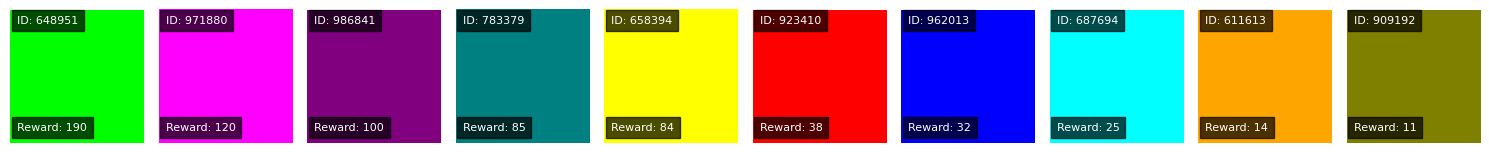

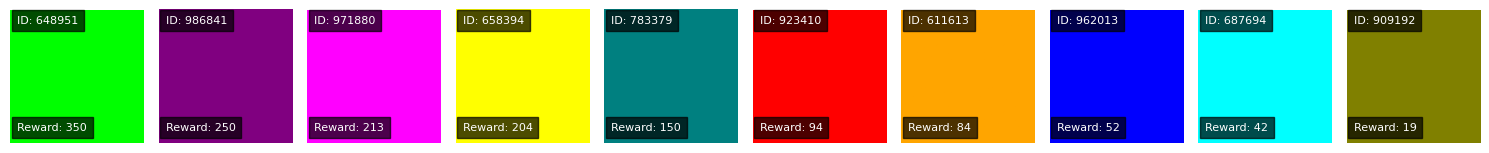

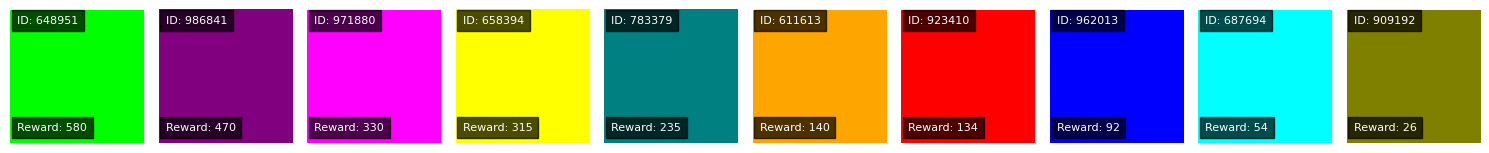

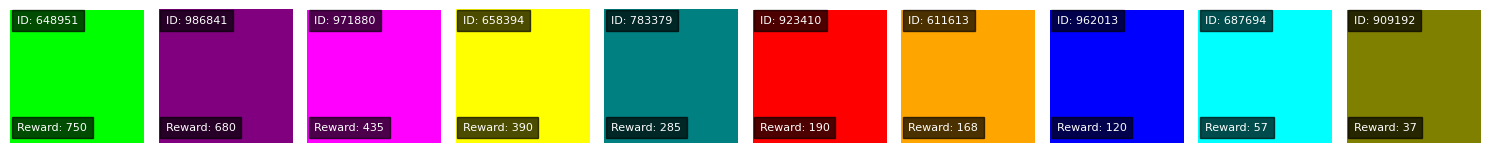

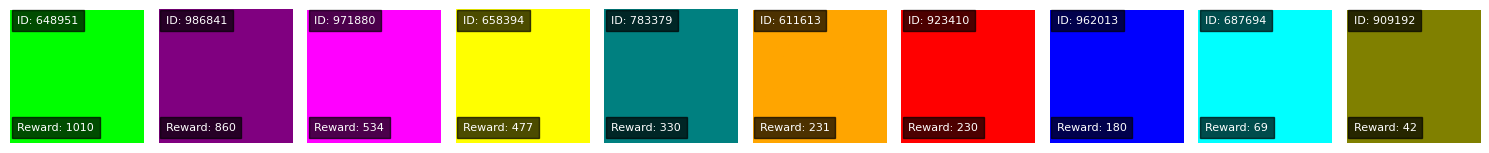

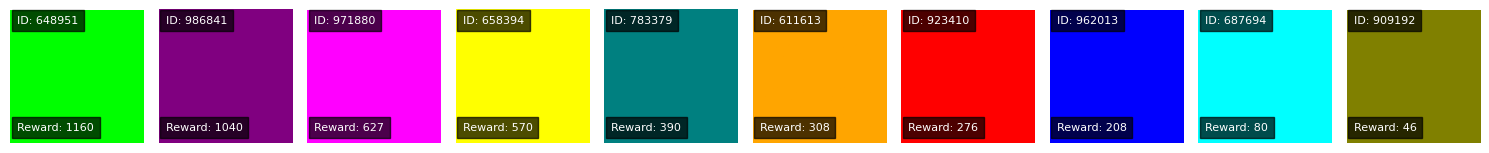

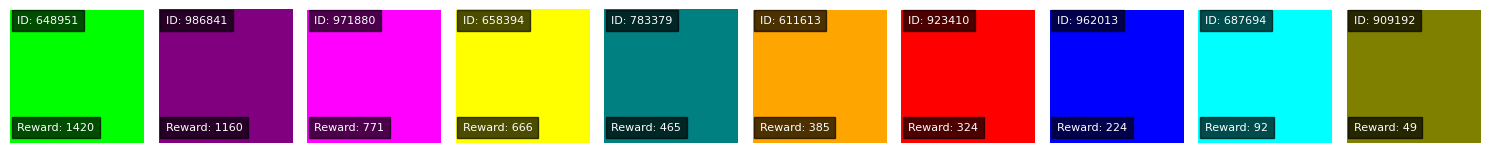

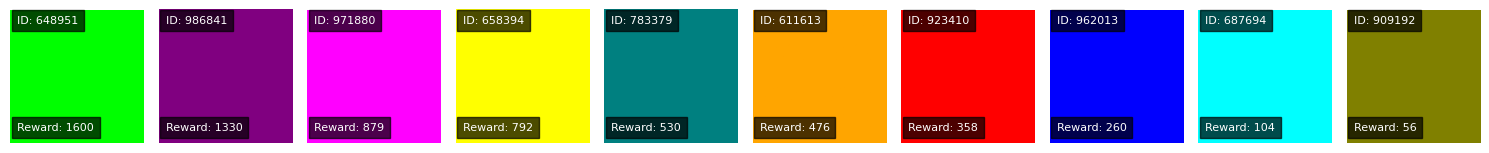

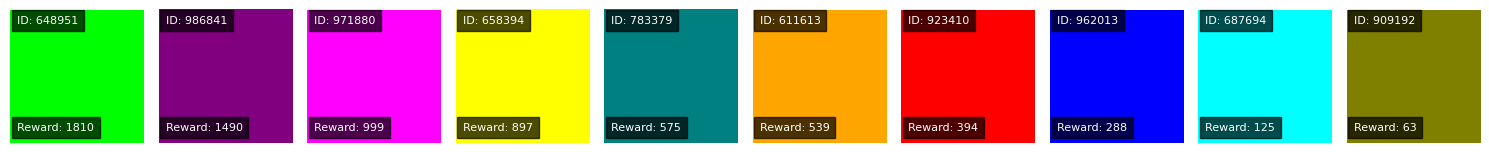

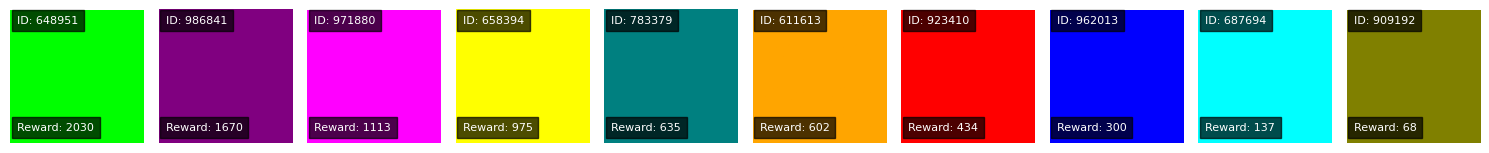

Epsilon Greedy Rewards: 7964


In [12]:
epsilon_greedy_bandit = EpsilonGreedyBandit(product_ids, business_objectives)
epsilon_greedy_rewards = simulate_user_interaction(epsilon_greedy_bandit)

print("Epsilon Greedy Rewards:", epsilon_greedy_rewards)

## Thompson Sampling Bandit

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*L0vvs3xcpRbuwb3ongHSNw.png)

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*3RH_JSGiqdzbZiJq-4hBcQ.png)

*Steve Roberts*

* Description: This Bayesian approach samples from the posterior distribution of each arm's reward and selects the arm with the highest sampled value.
* Pros: Adapts to non-stationary environments; balances exploration and exploitation effectively.
* Cons: Requires a prior distribution for rewards; can be computationally intensive, especially with complex priors.

https://www.youtube.com/watch?v=Zgwfw3bzSmQ

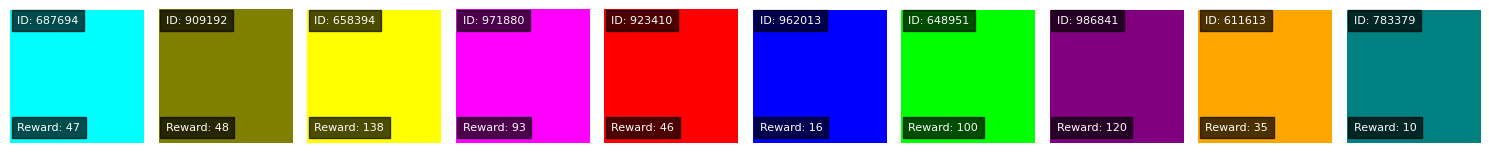

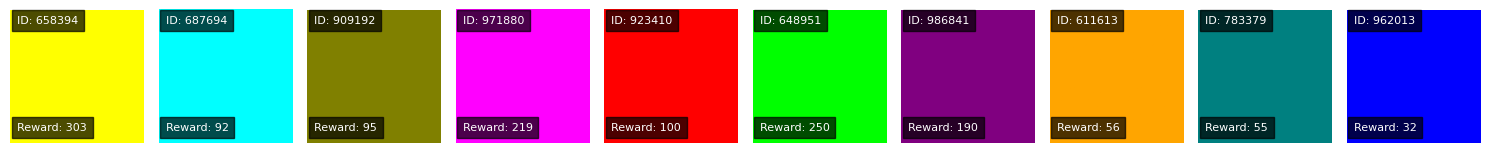

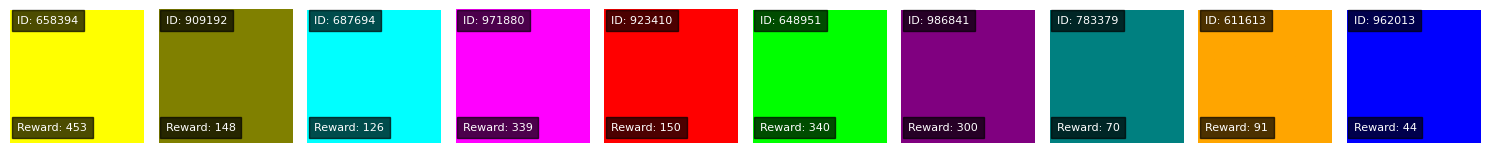

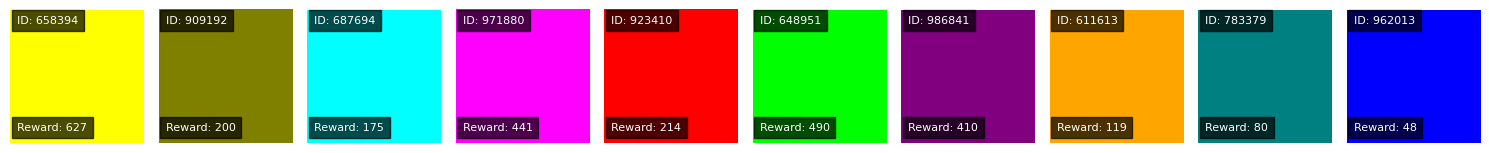

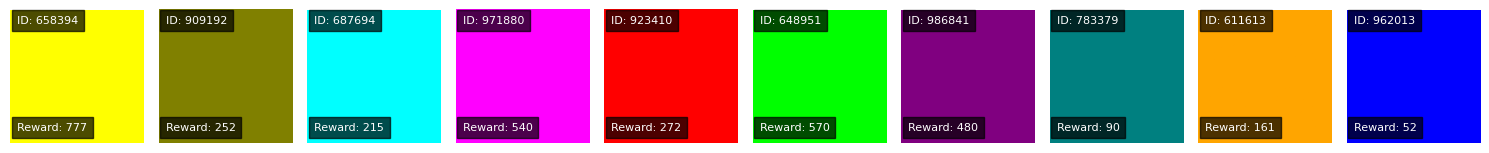

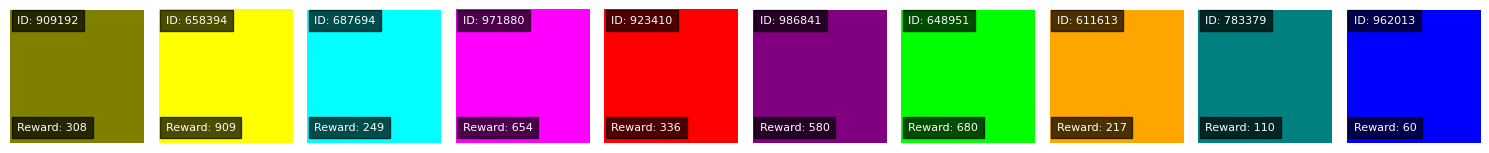

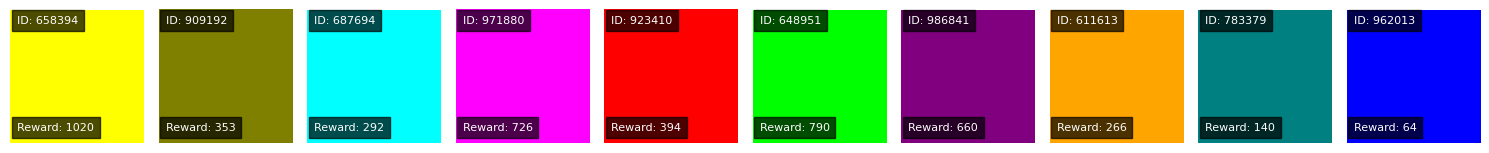

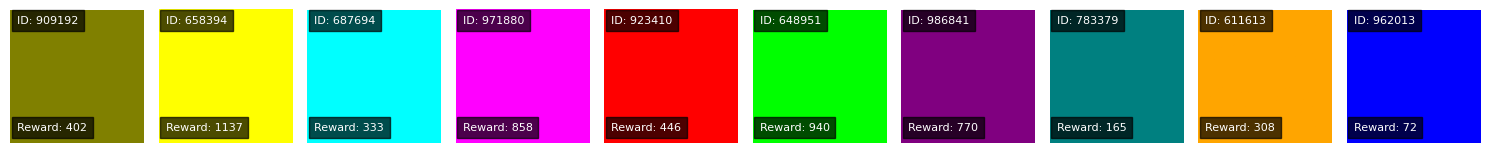

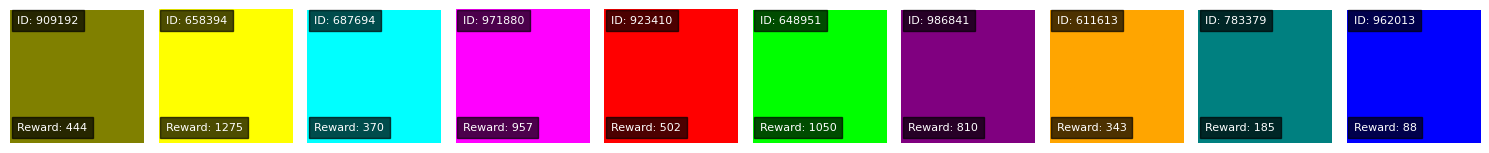

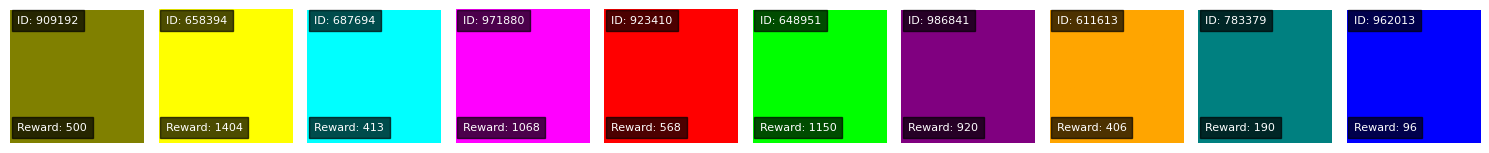

Thompson Sampling Rewards: 6715


In [13]:
thompson_sampling_bandit = ThompsonSamplingBandit(product_ids, business_objectives)
thompson_sampling_rewards = simulate_user_interaction(thompson_sampling_bandit)
print("Thompson Sampling Rewards:", thompson_sampling_rewards)



## Upper Confidence Bounds Bandit

![](https://eugeneyan.com/assets/ucb.jpg)

*Eugene Yan*

* Description: UCB selects the arm that has the highest upper bound on its potential true reward. The bound is based on the arm's average reward and the number of times it has been played.
* Pros: Takes into account both the uncertainty and the potential reward of each arm; reduces exploration over time.
* Cons: Assumes reward distributions are stationary; more computationally intensive than Epsilon-Greedy.

https://www.youtube.com/watch?v=FgmMK6RPU1c

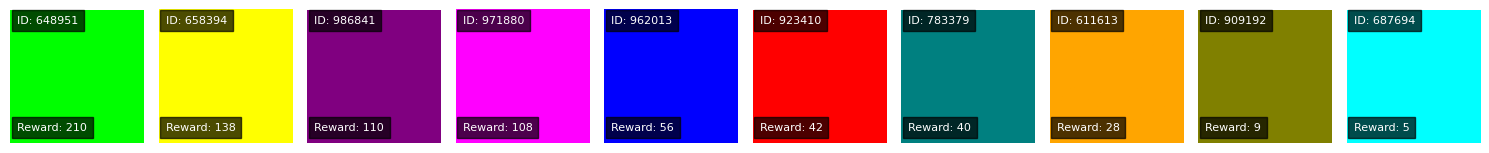

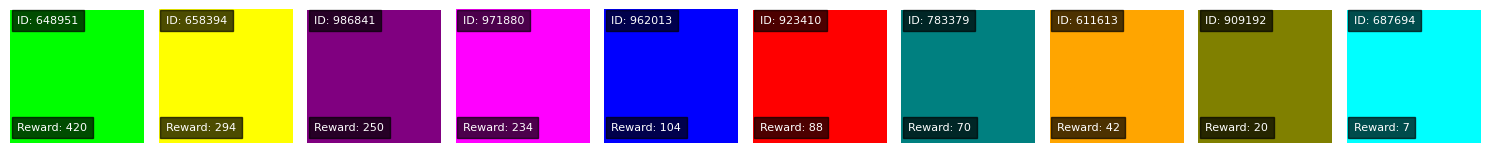

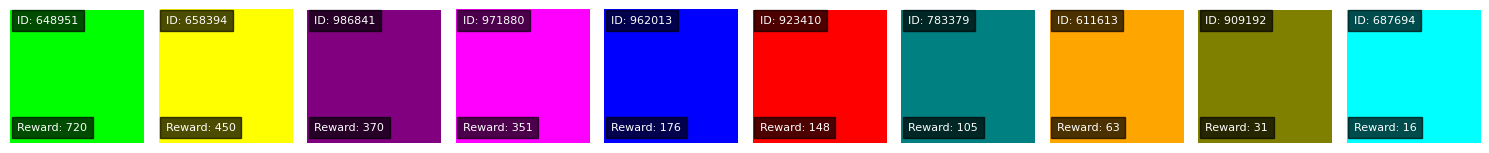

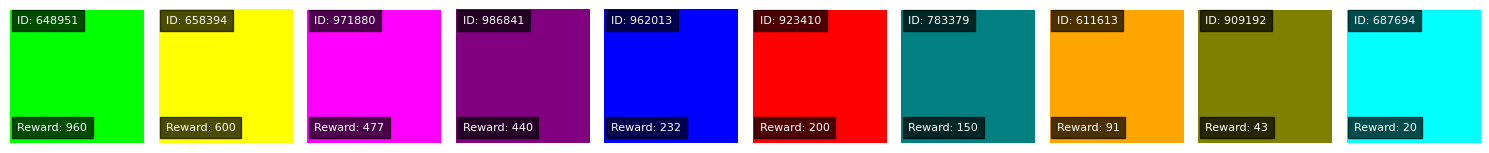

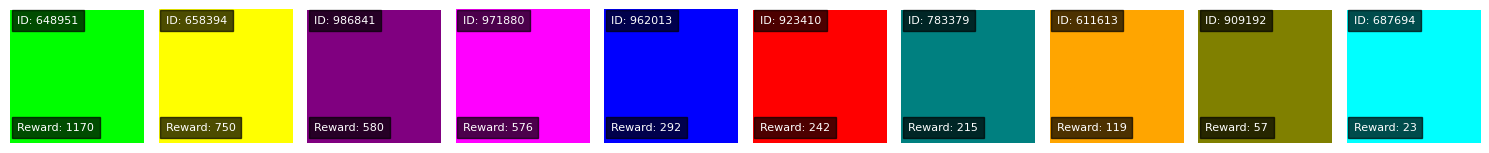

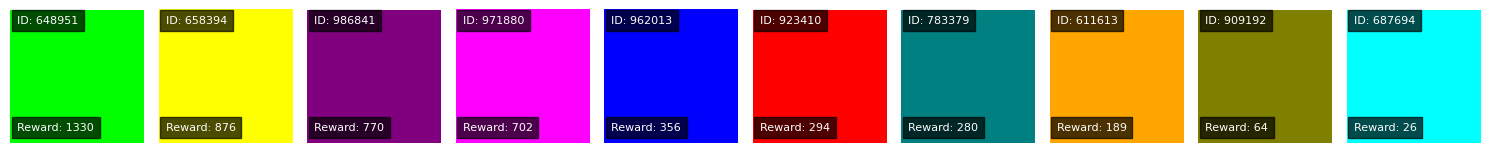

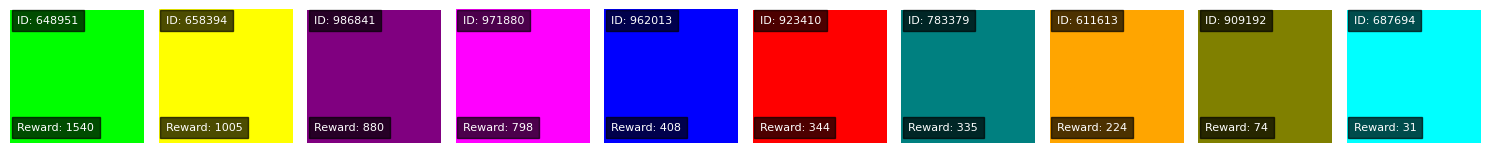

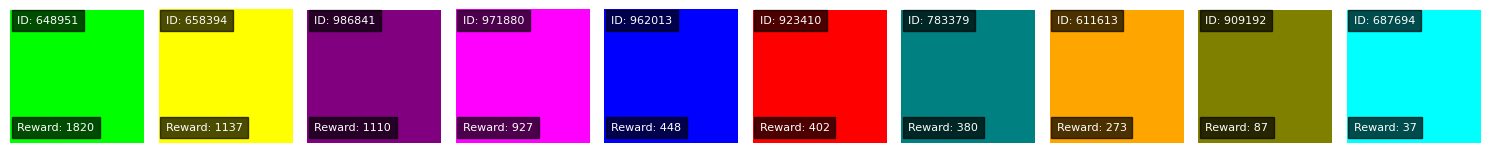

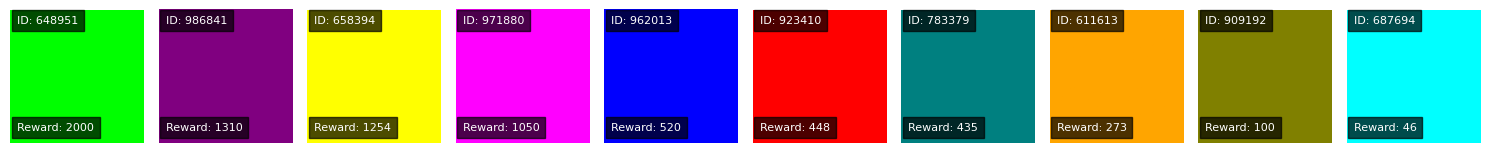

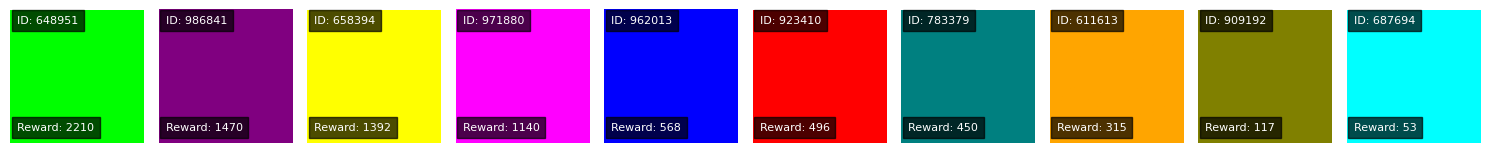

UCB Bandit Awards 8211


In [14]:
ucb_bandit = UCBBandit(product_ids, business_objectives)
ucb_rewards = simulate_user_interaction(ucb_bandit)
print("UCB Bandit Awards", ucb_rewards)